In [1]:
import numpy as np

from envs import ForbiddenAreaCfg, RewardCfg, make_gridworld
from common.vis import Visualizer
from common.policy import Policy


env = make_gridworld(
    forbidden_area_cfg=ForbiddenAreaCfg(
        locs=[[1, 1], [1, 2], [2, 2], [3, 1], [3, 3], [4, 1]]
    ),
    reward_cfg=RewardCfg(forbidden_area=-10, out_of_bound=-10, move=-1, target=0),
    start_loc=(0, 0),
    target_loc=(3, 2),
)

vis = Visualizer(env)

# 1. TD learning of state value

## A. State Value 

$v_{\pi}(s_t) = \mathbb{E}[G_t|S_t=s_t]$

or

$v_{\pi}(s_t) = \mathbb{E}[r_{t+1} + \gamma v_{\pi}(s_{t+1})]$

## B. Algorithm

We aim to estimate the state value of a given policy $\pi$.

Consider this formula:

$g(v_{\pi}(s_t)) = v_{\pi}(s_t) - \mathbb{E}[r_{t+1} + \gamma v_{\pi}(s_{t+1})|s_t]$

We can use Robbins-Monro algorithm to solve $g_t(v_{\pi}(s_t)) = 0$.

Then we have TD learning of state value algorithm:

$v_{t+1}(s_{t}) = v_{t}(s_t) - \alpha_t(s_t)[v_t(s_t) - [r_{t+1} + \gamma v_t(s_{t+1})]]$

This algorithm is driven by the temporal difference error and makes the state value estimate closer to the target value $\bar{v_t}$ ($\bar{v_t}$ is not the mean of $v_t$, it is an ideal value $v_{\pi}$).


## C. Properties

- It **only** estimates the state value of a given policy.
- It does not estimate the action value.
- It does not search for optimal policies.

# 1. TD learning of action value: Sarsa

## A. Action Value

$q_{\pi}(s_t, a_t) = \mathbb{E}[G_t|S_t=s_t, A_t=a_t]$

or

$q_{\pi}(s_t, a_t) = \mathbb{E}[r_{t+1} + \gamma v_{\pi}(s_{t+1})]$

## B. Algorithm

Suppose we have some experience/data $\{(s_t, a_t, r_{t+1}, s_{t+1}, a_{t+1})\}$.

We can use the following formula to estimate the action value:

$q_{t+1} = q_{t} - \alpha_t(s_t, a_t)[q_t(s_t, a_t) - [r_{t+1} + \gamma q_t(s_{t+1}, a_{t+1})]]$

> The above formula is to solve $g(q_{\pi}) = 0$,
>
> where $g(q_{\pi}(a_t, s_t)) = q_{\pi}(a_t, s_t) - \mathbb{E}[r_{t+1} + \gamma q_{\pi}(a_{t+1}, s_{t+1})|s_t, a_t]$

This formula is used to solve the Bellman equation in terms of action values:

$$
\begin{align*}
q_{\pi}(s, a) &= \sum_r rp(r|s, a) + \gamma\sum_{s'} \sum_{a'}q_{\pi}(s', a')p(s'|s, a)\pi(a'|s')\\
&= \sum_r rp(r|s, a) + \gamma \sum_{s'} p(s'|s, a) \sum_{a'}q_{\pi}(s', a')\pi(a'|s')\\\
&= \sum_r rp(r|s, a) + \gamma \sum_{s'} \sum_{a'} q_{\pi}(s', a') p(s', a'|s, a)\\
&= \mathbb{E}[r + \gamma q_{\pi}(s', a')|s, a]\\
\end{align*}
$$

where
$$
\begin{align*}
p(s', a'|s, a)
&= p(s'|s, a)p(a'|s', s, a)\\
&= p(s'|s, a)p(a'|s')\\
&= p(s'|s, a)\pi(a'|s')\\
\end{align*}
$$

In [2]:
num_episodes = 500
gamma = 0.9
alpha = 0.1

size: tuple[int, int] = env.unwrapped.size
target_loc: np.ndarray = env.unwrapped.target_loc

policy = Policy(env, eps=0.1)

In [3]:
Q = np.zeros((size[0], size[1], 5), dtype=np.float32)

for _ in range(num_episodes):
    obs, _ = env.reset()
    cur_loc: np.ndarray = obs["agent_loc"]
    cur_act = policy.get_action(cur_loc)
    lst_loc = cur_loc  # to update the (state, action) at the target loc

    while not np.array_equal(lst_loc, target_loc):
        obs, rwd, *_ = env.step(cur_act)

        nxt_loc = obs["agent_loc"]
        nxt_act = policy.get_action(nxt_loc)

        cur_idx, nxt_idx = tuple(cur_loc), tuple(nxt_loc)
        # Policy Evaluation
        Q[cur_idx][cur_act] -= alpha * (
            Q[cur_idx][cur_act] - rwd - gamma * Q[nxt_idx][nxt_act]
        )
        # Policy Improvement
        policy.improve(cur_loc, Q[cur_idx])

        # transition
        lst_loc = cur_loc
        cur_loc = nxt_loc
        cur_act = nxt_act

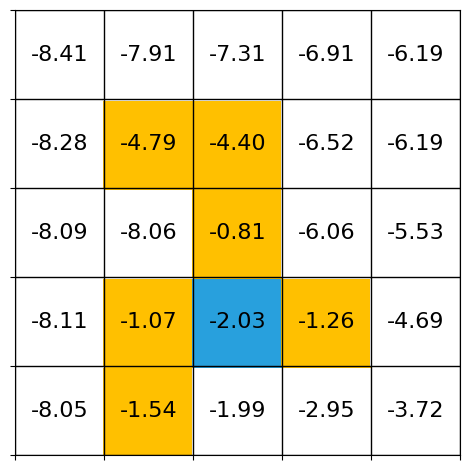

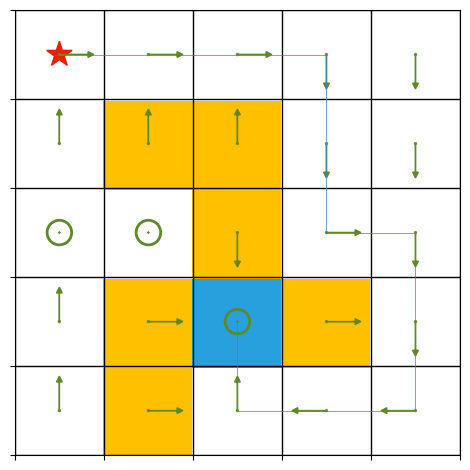

In [4]:
vis.draw_state_values(policy, Q)
vis.draw_strategy(policy, True)